# Artificial Neural Network with Keras 

**What is Keras?** Keras is a wrapper that allows you to implement (Deep) Neural Networks without getting into intrinsic details of the Network. It can use *Tensorflow* or *Theano* as backend. 


In this lab you will build a **ANN** (Perceptron/MLP) for image classification (classify whether an image contains an airplane or automobile or bird or cat or deer or dog or frog or horse or ship or truck).

# Importing libraries

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np

%matplotlib inline

# Importing Dataset

Here we are loading the cifar10 Dataset which is preloaded in tensorflow. <br>

Calling the `load_data` function on this object returns splitted train and test data in form of (features, target).

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Overview of Dataset

The CIFAR10 dataset contains 60,000 (32 x 32 pixel) color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.<br>
>The shape (50000, 32, 32, 3) represents **50000** images each of dimension **32 x 32 x 3**.<br>
The shape **(50000, )** represents (50000, 1) shape i.e. 50000 labels, each for one image.

In [3]:
print(f'Shape of the training data: {train_images.shape}')
print(f'Shape of the training target: {train_labels.shape}')
print(f'Shape of the test data: {test_images.shape}')
print(f'Shape of the test target: {test_labels.shape}')

Shape of the training data: (50000, 32, 32, 3)
Shape of the training target: (50000, 1)
Shape of the test data: (10000, 32, 32, 3)
Shape of the test target: (10000, 1)


In [4]:
print(train_labels)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


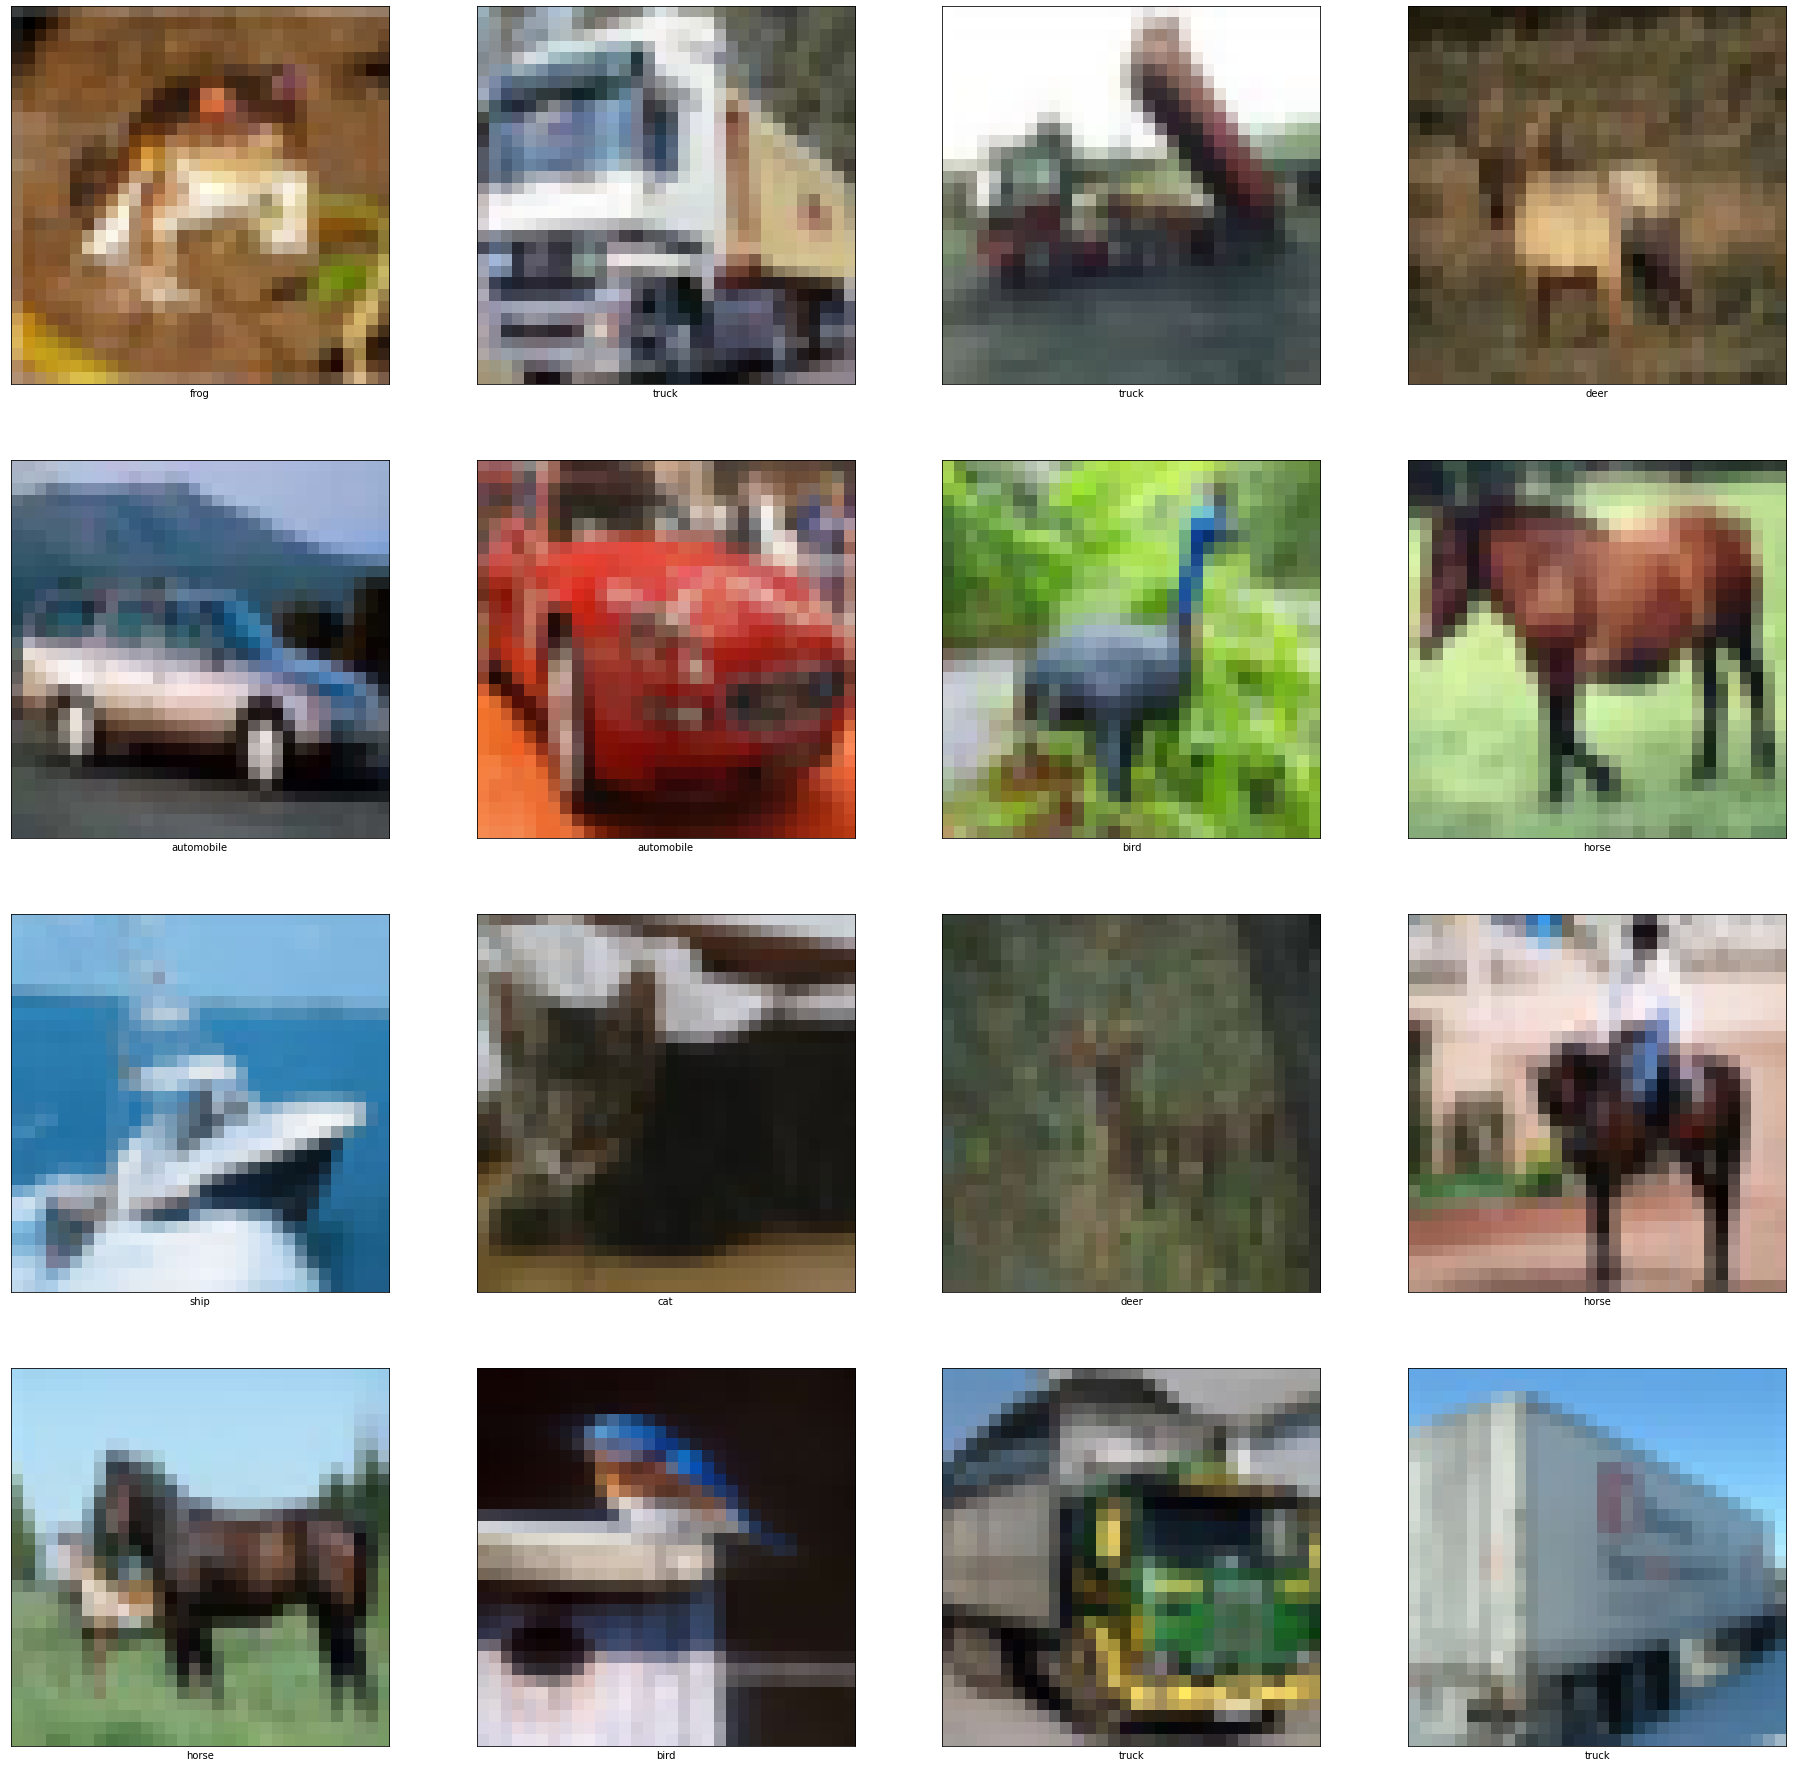

In [5]:
# To verify that the dataset looks correct, let's plot the first 16 images from the training set and display the class name below each image.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(32,32))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# Preprocessing

Normalizing i.e. scaling the pixels to 0-1 from 0-255.

In [6]:
# Normalizing
train_images, test_images = train_images / 255.0, test_images / 255.0


Or alternatively standardizing

In [7]:
#Standardizing 

def standardize(image_data):
        image_data = image_data.astype(float)
        image_data -= np.mean(image_data, axis=0)
        image_data /= np.std(image_data, axis=0)
        return image_data

train_images, test_images =   standardize(train_images), standardize(test_images)   

In [8]:
# convert to grayscale
#train_images, test_images = tf.image.rgb_to_grayscale(train_images), tf.image.rgb_to_grayscale(test_images)

# Modelling

There are two types of models in Tensorflow:
 - **Sequential**
 - **Graphical**

## Models
`tf.keras.model.Sequential()` 
lets you create a linear stack of layers providing a Sequential netural network.<br>
`tf.model()`
allows you to create arbitarary graph of layers as long as there is no cycle.

## Flatten Layer
`tf.keras.layers.Flatten()` flattens the input.<br>
For input of `(batch_size, height, width, depth)` the output converts to `(batch_size, height * width * depth)`

## Dense Layer
`tf.keras.layers.Dense()` Normal dense layer (= fully connected layer): each node/neuron in this layer is connected to each node in the input layer. <br>
>The two arguments passes below in dense layer are *units* and *activation* (activation function).<br>
* **units** corresponds to the number of nodes in the layer<br>
* **activation** is an element-wise activation function.
    * **'relu'**: This activation function converts every negative value to 0 and positive remains the same
    * **'softmax'**: This function takes as input a vector of K real numbers, and normalizes it into a probability distribution consisting of K probabilities proportional to the exponentials of the input numbers. The elements of the output vector are in range (0, 1) and sum to 1.
    * **'sigmoid'**: Applies the sigmoid activation function. For small values (<-5), sigmoid returns a value close to zero, and for large values (>5) the result of the function gets close to 1.
    * **'tanh'**: Applies the hyperbolic tangient function. The range of the tanh function is from (-1 to 1).
    * **None**: It means there is no activation function. In other words this layer produces linear output.


## Compiling model
`model.compile()` Sets up the optimiser, loss and metrics configuration.
> **optimizer**: updates the parameters (weights/biases) of the Neural Network. Some typical options:
* **'adam'**: Optimizer that implements the Adam algorithm. It is computationally efficient/fast, has little memory requirement and is well suited for problems that are large in terms of data/parameters. 
* **'SGD'**: Gradient descent (with momentum) optimizer.
Note: For both optimizers you need to define the learning rate

> **loss**: Measures the error in our model. Some typical options:
* **tf.keras.losses.CategoricalCrossentropy()**: Use this crossentropy loss function when there are two or more label classes (multi-class classification). We expect labels to be provided in a one_hot representation. 
* **tf.keras.losses.SparseCategoricalCrossentropy()**: Use this crossentropy loss function when there are two or more label classes (multi-class classification). We expect labels to be provided as integers.
* **tf.keras.losses.BinaryCrossentropy()**: Use this cross-entropy loss when there are only two label classes (assumed to be 0 and 1). It can also be used in multi-label classification cases.
* **tf.keras.losses.MAE()**:  Computes the mean absolute error between labels and predictions. It is mostly used in regression tasks.
* **tf.keras.losses.MSE()**: Computes the mean squared error between labels and predictions. It is mostly used in regression tasks.


> **metrics**: Used to judge the model. The difference between metrics and loss is that metrics in not used to evaluate the model while training, whereas loss evaluates the model error while training and helps optimizer reduce the error. All options can be found in: 
https://www.tensorflow.org/api_docs/python/tf/keras/metrics

# Creating the Model-Architecture

As input, a P/MLP takes tensors of shape (image_height x image_width x color_channels), ignoring the batch size; color_channels refer to (R,G,B). 
In this example, we will configure our ANN to process inputs of shape (32 x 32 x 3), which is the format of CIFAR images. We can do this by passing the argument input_shape to our first layer.
**Note** We only pass the argument input_shape to the first layer of the architecture. We do *not have to* pass it to any other layer.



In [9]:
model = models.Sequential()


model.add(layers.Flatten(input_shape=(  32 , 32 ,  3)))  # At first we flatten the image-matrix to a vector (format needed for the fully connected layer)
model.add(layers.Dense(1, activation=None))  
model.add(layers.Dense(10, activation="softmax"))  # output layer: there are 10 image categories (mutually exclusive); thus the layer should have 10 units; 
                                                   # activation function should be softmax that produces probabilities for the image categories

# as metric we choose the accuracy: the total number of correct predictions made
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



## Model details

Let's look at details of the model.


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3073      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20        
Total params: 3,093
Trainable params: 3,093
Non-trainable params: 0
_________________________________________________________________


## Training

```model.fit``` trains the model.
> * **train_images**: Training data/features
* **train_labels**: Target
* **epochs**: Number of times the entire dataset is fed in the model. In other words, one forward pass and one backward pass of all the training examples.
* **batch size**: Number of images that will be fed to the network at each iteration for optimizing. In other words, the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.


Epoch 1/20
196/196 [==============================] - 1s 3ms/step - loss: 2.2842 - accuracy: 0.1122 - val_loss: 2.2563 - val_accuracy: 0.1372
Epoch 2/20
196/196 [==============================] - 0s 2ms/step - loss: 2.2159 - accuracy: 0.1662 - val_loss: 2.1832 - val_accuracy: 0.1715
Epoch 3/20
196/196 [==============================] - 1s 3ms/step - loss: 2.1314 - accuracy: 0.1852 - val_loss: 2.0945 - val_accuracy: 0.1911
Epoch 4/20
196/196 [==============================] - 0s 2ms/step - loss: 2.0621 - accuracy: 0.1925 - val_loss: 2.0450 - val_accuracy: 0.1897
Epoch 5/20
196/196 [==============================] - 0s 2ms/step - loss: 2.0414 - accuracy: 0.1920 - val_loss: 2.0399 - val_accuracy: 0.1944
Epoch 6/20
196/196 [==============================] - 0s 2ms/step - loss: 2.0384 - accuracy: 0.1970 - val_loss: 2.0426 - val_accuracy: 0.1968
Epoch 7/20
196/196 [==============================] - 0s 2ms/step - loss: 2.0360 - accuracy: 0.1964 - val_loss: 2.0343 - val_accuracy: 0.1956
Epoch 

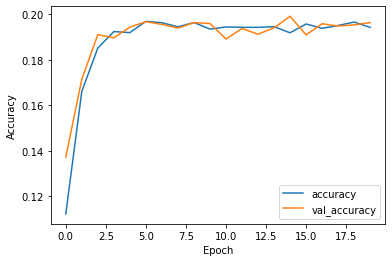

In [11]:
# Training
history = model.fit(train_images, train_labels, epochs=20, batch_size=256, 
                    validation_data=(test_images, test_labels))

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [12]:
predictions = model.predict(test_images)
predictions[0]

array([0.05343851, 0.05214063, 0.13965692, 0.14421372, 0.130985  ,
       0.14116909, 0.12004051, 0.14210206, 0.02950525, 0.04674828],
      dtype=float32)

In [13]:
predictions_index = np.argmax(predictions, axis=1) # Convert one-hot to index; remember indexing starts from 0; index takes integers values in [0,9]
predictions_index

array([3, 8, 8, ..., 6, 3, 3])

## Visualize prediction

Now let's visualize the prediction using the model you just trained. 
First we get the predictions with the model from the test data.
Then we print out 15 images from the test data set, and set the titles with the prediction (and the ground truth label).
If the prediction matches the true label, the title will be green; otherwise it's displayed in red.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

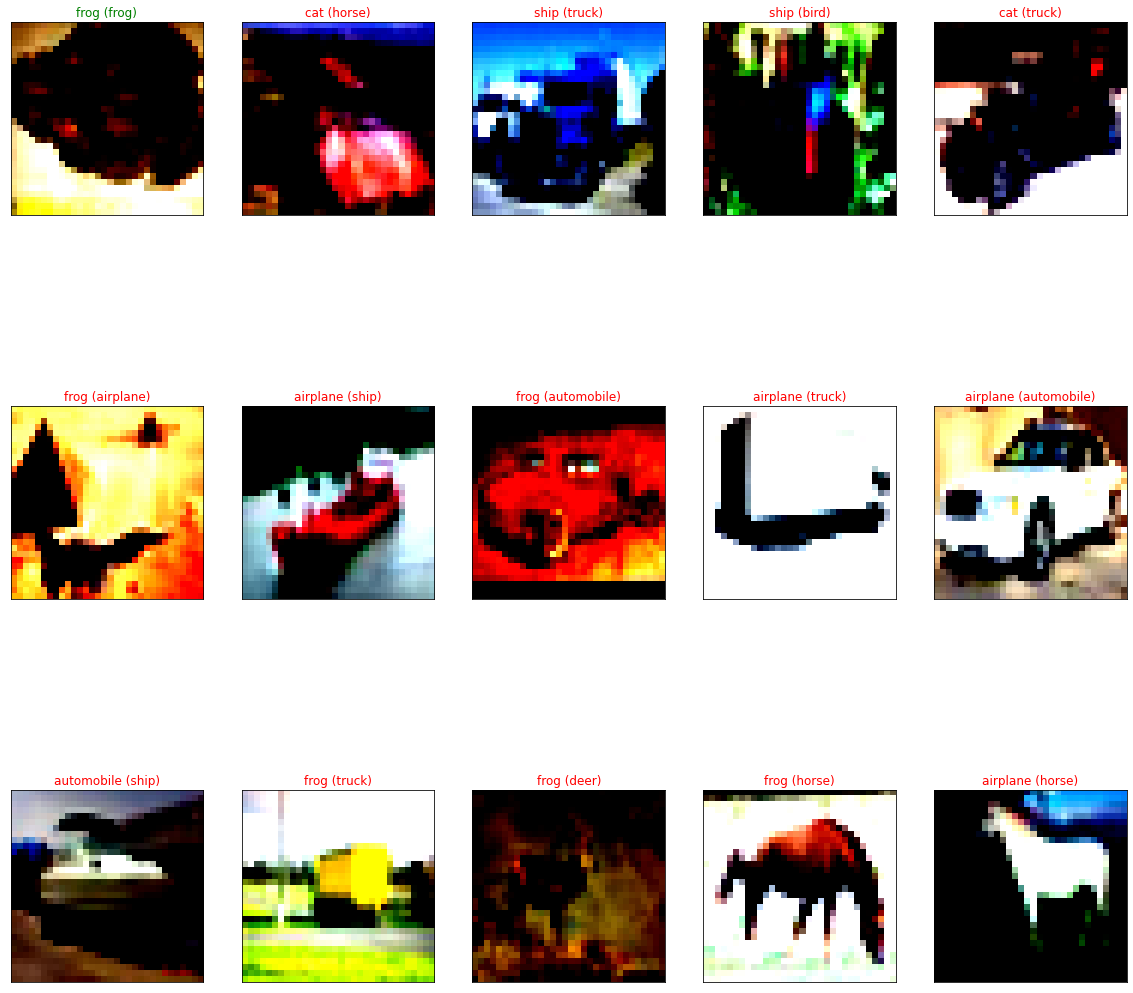

In [14]:
import pdb
y_hat = model.predict(test_images)

# Plot a random sample of 15 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 20))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = test_labels[index][0]
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Try/Check the following (in random order)

1) Standardization vs Normalization </br>
2) Graysclale vs RGB </br>
3) Adding more hidden units to the network </br>
4) Adding more layers to the network </br>
5) Using different activation functions in the hidden units </br>
6) Using different optimizers </br>
7) Using different learning rates </br>
8) Using different batch size (what's the difference in the performance and in the training time) </br>
9) Train for more epochs </br>


